In [1]:
from kan.hypothesis import *
from torchvision import transforms
import torch
import torch.nn.functional as F
from kan import *
import h5py
import copy
import sympy as sp
dtype = torch.get_default_dtype()
from sympy import latex
import pickle

In [2]:
data_dir = "./"
filename = "sg2-data.h5"
checkpoint_dir = "./saved_models/"
log_dir = './logs/'
band_idx = 0
gidxs = [1, 2, 3, 4]
only_obstructed = False
only_topological = False
binary_classification = False#True
no_penalize_last = True
bias = False
numrs = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
file = h5py.File(data_dir + filename, 'r')
print("file keys: ", file['sg2/1/'].keys());

file keys:  <KeysViewHDF5 ['epsilon_Gs-gidx=1', 'epsilon_Gs-gidx=2', 'epsilon_Gs-gidx=3', 'epsilon_Gs-gidx=4', 'frequencies-gidx=1-mode=tm', 'frequencies-gidx=2-mode=tm', 'frequencies-gidx=3-mode=tm', 'frequencies-gidx=4-mode=tm', 'symmetry-gidx=1-mode=tm', 'symmetry-gidx=2-mode=tm', 'symmetry-gidx=3-mode=tm', 'symmetry-gidx=4-mode=tm']>


In [4]:
nGs = 10
gidxs = [1, 2, 3, 4]
wps = ['1a', '1b', '1c', '1d']
wps2 = ['1a', '1c', '1b', '1d'] # switch 1b and 1c due to convention of how Gvectors are stored

symmetry_data = torch.zeros(10000 * len(gidxs) * len(wps))
input_data = torch.zeros(10000 * len(gidxs) * len(wps), nGs)

In [5]:
for (widx, (wp1, wp2)) in enumerate(zip(wps, wps2)):
    print(f"Wyckoff index: {widx}")
    sym_vec_phases = file[f'sg2/symmetry_vector_phases/{wp1}'][()]
    epsilon_G_phases = file[f'sg2/epsilon_G_phases/{wp2}'][()].real
    for gidx in gidxs:
        print(f"gidx: {gidx}")
        for id in range(1, 10001):
            real_id = (id-1) + (gidx-1)*10000 + len(gidxs)*10000*widx
            if (id % 1000 == 0): 
                print(id)
            symmetry_before_aug = file[f'sg2/{id}/symmetry-gidx={gidx}-mode=tm'][()][band_idx]
            if band_idx == 0:
                symmetry_data[real_id] =  sym_vec_phases[symmetry_before_aug] - 8
            else: 
                symmetry_data[real_id] =  sym_vec_phases[symmetry_before_aug] 

            fourier_data_before_aug = file[f'sg2/{id}/epsilon_Gs-gidx={gidx}'][()][0:nGs].real
            fourier_data = fourier_data_before_aug * epsilon_G_phases
            input_data[real_id, :] = torch.tensor([*fourier_data])

Wyckoff index: 0
gidx: 1
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
gidx: 2
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
gidx: 3
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
gidx: 4
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
Wyckoff index: 1
gidx: 1
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
gidx: 2
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
gidx: 3
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
gidx: 4
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
Wyckoff index: 2
gidx: 1
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
gidx: 2
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
gidx: 3
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
gidx: 4
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
Wyckoff index: 3
gidx: 1
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
gidx: 2
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
gidx: 3
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
gidx: 4
1000
2000
3000
4000
5000
6000
7000
8000

### Below, we make $2\times 11$ datasets, the first seven corresponding to training tests of sizes: $8, 16, 32, 64, 128, 256, 512$ and the second half having the same data but with augmentations (so four times the amount of data in each)

In [6]:
training_inputs_no_aug = []
training_inputs_aug = []

training_labels_no_aug = []
training_labels_aug = []

training_set_sizes = np.array([8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192])

In [7]:
N = 10000 * len(gidxs)
for s in training_set_sizes:
    shuffled_indices_no_aug = torch.randperm(N)[0:s] # from 0 to 40,000
    shuffled_indices_aug = torch.cat([shuffled_indices_no_aug + i*N for i in range(0, 4)])

    shuffled_indices_aug = shuffled_indices_aug[torch.randperm(4*s)]
    
    training_inputs_no_aug.append(input_data[shuffled_indices_no_aug, :])
    training_inputs_aug.append(input_data[shuffled_indices_aug, :])

    training_labels_no_aug.append(symmetry_data[shuffled_indices_no_aug])
    training_labels_aug.append(symmetry_data[shuffled_indices_aug])

### Check that augmented datasets correspond correctly to un-augmented datasets

In [38]:
for training_input_aug in training_inputs_aug:
    num_unique_elements = training_input_aug.abs().unique(dim=0).shape[0]
    print("Number of unique data elements given by: ", num_unique_elements )

Number of unique data elements given by:  8
Number of unique data elements given by:  16
Number of unique data elements given by:  32
Number of unique data elements given by:  64
Number of unique data elements given by:  128
Number of unique data elements given by:  256
Number of unique data elements given by:  512
Number of unique data elements given by:  1024
Number of unique data elements given by:  2048
Number of unique data elements given by:  4096
Number of unique data elements given by:  8192


### Run without augmentation

In [125]:
training_accs_no_aug = []
testing_accs_no_aug = []

for (training_input_no_aug, training_label_no_aug) in zip(training_inputs_no_aug, training_labels_no_aug):
    print("Training input size: ", training_input_no_aug.shape)
    print("Training label size: ", training_label_no_aug.shape)

    dataset_kan = {}
    nGs = 10
    nGstart = 1
    
    dataset_kan['train_input'] = training_input_no_aug[:, [*range(nGstart, nGs)]].to(device)
    dataset_kan['train_label'] = training_label_no_aug.long().to(device)
    
    # Put all data in test datasets
    dataset_kan['test_input'] = input_data[:, [*range(nGstart, nGs)]].to(device)
    dataset_kan['test_label'] = symmetry_data.long().to(device)
    
    n_class = 16
    if band_idx == 0:
        n_class = 8
    model = KAN(width=[9, 24, n_class], grid=5, k=1, seed=1, device=device)
    lr = 1
    def train_acc():
        return torch.mean((torch.argmax(model(dataset_kan['train_input']), dim=1) == dataset_kan['train_label']).type(dtype))
    
    def test_acc():
        return torch.mean((torch.argmax(model(dataset_kan['test_input']), dim=1) == dataset_kan['test_label']).type(dtype))
        
    results = model.fit(dataset_kan, opt="LBFGS", steps=100, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss(), lr=lr);
    model.attribute()
    print("Train accuracy: ", round(results['train_acc'][-1]*100, 2),  " Test accuracy: ", round(results['test_acc'][-1]*100, 2))
    training_accs_no_aug.append(round(results['train_acc'][-1]*100, 2))
    testing_accs_no_aug.append(round(results['test_acc'][-1]*100, 2))


Training input size:  torch.Size([8, 10])
Training label size:  torch.Size([8])
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.22e-04 | test_loss: 4.05e+00 | reg: 3.96e+02 | : 100%|█| 100/100 [00:09<00:00, 10.61


saving model version 0.1
Train accuracy:  100.0  Test accuracy:  14.69
Training input size:  torch.Size([16, 10])
Training label size:  torch.Size([16])
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 0.00e+00 | test_loss: 5.25e+00 | reg: 6.53e+02 | : 100%|█| 100/100 [00:08<00:00, 11.28


saving model version 0.1
Train accuracy:  100.0  Test accuracy:  27.84
Training input size:  torch.Size([32, 10])
Training label size:  torch.Size([32])
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 0.00e+00 | test_loss: 3.95e+00 | reg: 7.32e+02 | : 100%|█| 100/100 [00:09<00:00, 10.64


saving model version 0.1
Train accuracy:  100.0  Test accuracy:  30.25
Training input size:  torch.Size([64, 10])
Training label size:  torch.Size([64])
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 0.00e+00 | test_loss: 3.71e+00 | reg: 7.45e+02 | : 100%|█| 100/100 [00:09<00:00, 10.73


saving model version 0.1
Train accuracy:  100.0  Test accuracy:  48.72
Training input size:  torch.Size([128, 10])
Training label size:  torch.Size([128])
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.18e-04 | test_loss: 1.56e+00 | reg: 6.18e+02 | : 100%|█| 100/100 [00:09<00:00, 10.47


saving model version 0.1
Train accuracy:  100.0  Test accuracy:  74.1
Training input size:  torch.Size([256, 10])
Training label size:  torch.Size([256])
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.21e-04 | test_loss: 9.15e-01 | reg: 9.25e+02 | : 100%|█| 100/100 [00:07<00:00, 13.88


saving model version 0.1
Train accuracy:  100.0  Test accuracy:  91.44
Training input size:  torch.Size([512, 10])
Training label size:  torch.Size([512])
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.35e-03 | test_loss: 8.20e-01 | reg: 1.05e+03 | : 100%|█| 100/100 [00:07<00:00, 13.61


saving model version 0.1
Train accuracy:  100.0  Test accuracy:  94.26
Training input size:  torch.Size([1024, 10])
Training label size:  torch.Size([1024])
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.85e-05 | test_loss: 8.31e-01 | reg: 9.80e+02 | : 100%|█| 100/100 [00:09<00:00, 10.50


saving model version 0.1
Train accuracy:  100.0  Test accuracy:  95.58
Training input size:  torch.Size([2048, 10])
Training label size:  torch.Size([2048])
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.40e-04 | test_loss: 8.00e-01 | reg: 1.06e+03 | : 100%|█| 100/100 [00:08<00:00, 12.08


saving model version 0.1
Train accuracy:  100.0  Test accuracy:  96.72
Training input size:  torch.Size([4096, 10])
Training label size:  torch.Size([4096])
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.41e-05 | test_loss: 6.02e-01 | reg: 9.83e+02 | : 100%|█| 100/100 [00:11<00:00,  8.85


saving model version 0.1
Train accuracy:  100.0  Test accuracy:  98.24
Training input size:  torch.Size([8192, 10])
Training label size:  torch.Size([8192])
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.19e-05 | test_loss: 6.91e-01 | reg: 1.50e+03 | : 100%|█| 100/100 [00:12<00:00,  7.81

saving model version 0.1
Train accuracy:  100.0  Test accuracy:  98.68


In [126]:
training_accs_aug = []
testing_accs_aug = []

for (training_input_aug, training_label_aug) in zip(training_inputs_aug, training_labels_aug):
    print("Training input size: ", training_input_aug.shape)
    print("Training label size: ", training_label_aug.shape)

    dataset_kan = {}
    nGs = 10
    nGstart = 1
    
    dataset_kan['train_input'] = training_input_aug[:, [*range(nGstart, nGs)]].to(device)
    dataset_kan['train_label'] = training_label_aug.long().to(device)
    
    # Put all data in test datasets
    dataset_kan['test_input'] = input_data[:, [*range(nGstart, nGs)]].to(device)
    dataset_kan['test_label'] = symmetry_data.long().to(device)
    
    n_class = 16
    if band_idx == 0:
        n_class = 8
    model = KAN(width=[9, 24, n_class], grid=5, k=1, seed=1, device=device)
    lr = 1
    def train_acc():
        return torch.mean((torch.argmax(model(dataset_kan['train_input']), dim=1) == dataset_kan['train_label']).type(dtype))
    
    def test_acc():
        return torch.mean((torch.argmax(model(dataset_kan['test_input']), dim=1) == dataset_kan['test_label']).type(dtype))
        
    results = model.fit(dataset_kan, opt="LBFGS", steps=100, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss(), lr=lr);
    model.attribute()
    print("Train accuracy: ", round(results['train_acc'][-1]*100, 2),  " Test accuracy: ", round(results['test_acc'][-1]*100, 2))
    training_accs_aug.append(round(results['train_acc'][-1]*100, 2))
    testing_accs_aug.append(round(results['test_acc'][-1]*100, 2))


Training input size:  torch.Size([32, 10])
Training label size:  torch.Size([32])
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 0.00e+00 | test_loss: 2.79e+00 | reg: 5.41e+02 | : 100%|█| 100/100 [00:09<00:00, 11.02


saving model version 0.1
Train accuracy:  100.0  Test accuracy:  35.37
Training input size:  torch.Size([64, 10])
Training label size:  torch.Size([64])
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.32e-05 | test_loss: 2.29e+00 | reg: 8.54e+02 | : 100%|█| 100/100 [00:09<00:00, 11.03


saving model version 0.1
Train accuracy:  100.0  Test accuracy:  68.66
Training input size:  torch.Size([128, 10])
Training label size:  torch.Size([128])
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 0.00e+00 | test_loss: 1.77e+00 | reg: 8.03e+02 | : 100%|█| 100/100 [00:09<00:00, 10.39


saving model version 0.1
Train accuracy:  100.0  Test accuracy:  78.71
Training input size:  torch.Size([256, 10])
Training label size:  torch.Size([256])
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.74e-05 | test_loss: 8.73e-01 | reg: 5.95e+02 | : 100%|█| 100/100 [00:08<00:00, 11.41


saving model version 0.1
Train accuracy:  100.0  Test accuracy:  91.34
Training input size:  torch.Size([512, 10])
Training label size:  torch.Size([512])
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.78e-05 | test_loss: 9.70e-01 | reg: 1.12e+03 | : 100%|█| 100/100 [00:07<00:00, 13.64


saving model version 0.1
Train accuracy:  100.0  Test accuracy:  93.34
Training input size:  torch.Size([1024, 10])
Training label size:  torch.Size([1024])
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.41e-04 | test_loss: 7.14e-01 | reg: 9.28e+02 | : 100%|█| 100/100 [00:08<00:00, 12.29


saving model version 0.1
Train accuracy:  100.0  Test accuracy:  95.89
Training input size:  torch.Size([2048, 10])
Training label size:  torch.Size([2048])
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.96e-05 | test_loss: 7.73e-01 | reg: 9.27e+02 | : 100%|█| 100/100 [00:09<00:00, 10.12


saving model version 0.1
Train accuracy:  100.0  Test accuracy:  96.51
Training input size:  torch.Size([4096, 10])
Training label size:  torch.Size([4096])
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.59e-04 | test_loss: 7.57e-01 | reg: 1.17e+03 | : 100%|█| 100/100 [00:08<00:00, 11.51


saving model version 0.1
Train accuracy:  100.0  Test accuracy:  98.47
Training input size:  torch.Size([8192, 10])
Training label size:  torch.Size([8192])
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.91e-05 | test_loss: 6.52e-01 | reg: 1.31e+03 | : 100%|█| 100/100 [00:11<00:00,  8.47


saving model version 0.1
Train accuracy:  100.0  Test accuracy:  98.46
Training input size:  torch.Size([16384, 10])
Training label size:  torch.Size([16384])
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.75e-05 | test_loss: 3.88e-01 | reg: 1.22e+03 | : 100%|█| 100/100 [00:16<00:00,  6.14


saving model version 0.1
Train accuracy:  100.0  Test accuracy:  99.21
Training input size:  torch.Size([32768, 10])
Training label size:  torch.Size([32768])
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.73e-03 | test_loss: 2.78e-01 | reg: 1.20e+03 | : 100%|█| 100/100 [00:31<00:00,  3.15

saving model version 0.1
Train accuracy:  100.0  Test accuracy:  99.38


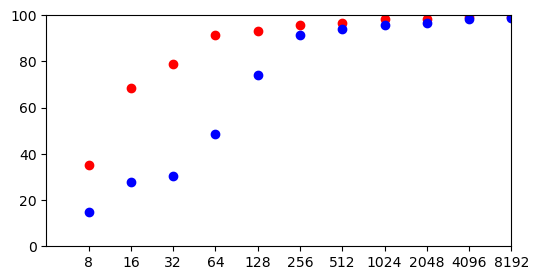

In [151]:
fig, ax = plt.subplots(figsize=(6, 3))
plt.scatter(range(0, 11), testing_accs_aug, color="red")
plt.scatter(range(0, 11), testing_accs_no_aug, color="blue")
ax.set_ylim(0, 100)
ax.set_xlim(-1, 10)
ax.set_xticks(range(0, 11), [2**(x+3) for x in range(0, 11)] );
plt.savefig("./figures/Augmentation_accuracy_increase.pdf")